# Solving homophonic substitution ciphers

Sam Blake, started May 2021

In [1]:
import math
import numpy as np
import pandas as pd
import collections
import string
import random
import copy
import time
import json

In [369]:
from numba import jit

### Sample plaintext

In [2]:
z408_plaintext = 'I LIKE KILLING PEOPLE BECAUSE IT IS SO MUCH FUN IT IS MORE FUN \
THAN KILLING WILD GAME IN THE FORREST BECAUSE MAN IS THE MOAT DANGEROUE \
ANAMAL OF ALL TO KILL SOME THING GIVES ME THE MOAT THRILLING EXPERENCE IT IS EVEN \
BETTER THAN GETTING YOUR ROCKS OFF WITH A GIRL THE BEST PART OF IT IA THAE WHEN I \
DIE I WILL BE REBORN IN PARADICE SND ALL THE I HAVE KILLED WILL BECOME MY SLAVES I \
WILL NOT GIVE YOU MY NAME BECAUSE YOU WILL TRY TO SLOI DOWN OR STOP MY COLLECTING \
OF SLAVES FOR MY AFTERLIFE EBEORIETEMETHHPITI'.replace(' ', '')

In [3]:
z340_plaintext = 'I HOPE YOU ARE HAVING LOTS OF FUN IN TRYING TO CATCH ME THAT WASNT ME ON \
THE TV SHOW WHICH BRINGS UP A POINT ABOUT ME I AM NOT AFRAID OF THE GAS CHAMBER BECAUSE IT WILL \
SEND ME TO PARADICE ALL THE SOONER BECAUSE I NOW HAVE ENOUGH SLAVES TO WORK FOR ME WHERE EVERYONE \
ELSE HAS NOTHING WHEN THEY REACH PARADICE SO THEY ARE AFRAID OF DEATH I AM NOT AFRAID BECAUSE I \
KNOW THAT MY NEW LIFE WILL BE AN EASY ONE IN PARADICE LIFE IS DEATH'.replace(' ', '')

In [291]:
# Shamelessly used without permission. 
singh_codebook_plaintext = "For centuries kings queens and generals have relied on efficient \
communication in order to \
govern their countries and command their armies At the same time they have all been aware of \
the consequences of their messages falling into the wrong hands revealing precious secrets to \
rival nations and betraying vital information to opposing forces It was the threat of enemy \
interception that motivated the development of codes and ciphers techniques for disguising a \
message so that only the intended recipient can read it \
The desire for secrecy has meant that nations have operated codemaking departments which were \
responsible for ensuring the security of communications by inventing and implementing the best \
possible codes At the same time enemy code breakers have attempted to break these codes and steal \
secrets Codebreakers are linguistic alchemists a mystical tribe at tempting to conjure sensible \
words out of meaningless symbols The history of codes and ciphers is the story of the centuries \
old battle between codemakers and codebreakers an intellectual arms race that has had a dramatic \
impact on the course of history In writing The Code Book I have had two main objectives The first \
is to chart the evolution of codes Evolution is a wholly appropriate term because the development \
of codes can be viewed as an evolutionary struggle A code is constantly under attack from \
codebreakers When the codebreakers have developed a new weapon that reveals a codes weakness then \
the code is no longer useful It either becomes extinct or it evolves into a new stronger code In \
turn this new code thrives only until the codebreakers identify its weakness and so on This is \
similar to the situation facing for example a strain of infectious bacteria The bacteria live \
thrive and survive until doctors discover an antibiotic that exposes a weakness in the bacteria \
and kills them The bacteria are forced to evolve and outwit the antibiotic and if successful \
they will thrive once again and reestablish themselves".upper().replace(' ','')

### Ciphers

In [5]:
z340_untransposed = "H+M8|CV@KEB+*5k.L\
dR(UVFFz9<>#Z3P>L\
(MpOGp+2|G+l%WO&D\
#2b^D(+4(5J+VW)+k\
p+fZPYLR/8KjRk.#K\
_Rq#2|<z29^%OF1*H\
SMF;+BLKJp+l2_cTf\
BpzOUNyG)y7t-cYA2\
N:^j*Xz6dpclddG+4\
-RR+4Ef|pz/JNb>M)\
+l5||.VqL+Ut*5cUG\
R)VE5FVZ2cW+|TB45\
|TC^D4ct-c+zJYM(+\
y.LW+B.;+B31cOp+8\
lXz6Ppb&RG+BCOTBz\
F1K<SMF6N*(+HK29^\
:OFTO<Sf4pl/Ucy59\
^W(+l#2C.B)7<FBy-\
dkF|W<7t_BOYB*-CM\
>cHD8OZzSkpNA|K;+"

In [228]:
z408_ciphertext = "9%P/Z/UB%kOR=pX=B\
WV+eGYF69HP@K!qYe\
MJY^UIk7qTtNQYD5)\
S(/9#BPORAU%fRlqE\
k^LMZJdr\\pFHVWe8Y\
@+qGD9KI)6qX85zS(\
RNtIYElO8qGBTQS#B\
Ld/P#B@XqEHMU^RRk\
cZKqpI)Wq!85LMr9#\
BPDR+j=6\\N(eEUHkF\
ZcpOVWI5+tL)l^R6H\
I9DR_TYr\\de/@XJQA\
P5M8RUt%L)NVEKH=G\
rI!Jk598LMlNA)Z(P\
zUpkA9#BVW\\+VTtOP\
^=SrlfUe67DzG%%IM\
Nk)ScE/9%%ZfAP#BV\
peXqWq_F#8c+@9A9B\
%OT5RUc+_dYq_^SqW\
VZeGYKE_TYA9%#Lt_\
H!FBX9zXADd\\7L!=q\
_ed##6e5PORXQF%Gc\
Z@JTtq_8JI+rBPQW6\
VEXr9WI6qEHM)=UIk"
len(z408_ciphertext)

408

### Create homophonic substitution cipher

TODO: implement non-cyclic symbol assignments. 

In [6]:
def generate_homophonic_substitution_cipher(plaintext, n_symbols = 64):
    
    tally = {letter: plaintext.count(letter) for letter in set(plaintext)}
    plaintext_chars = list(tally.keys())
    plaintext_freqs = np.array(list(tally.values()))
    
    # Get frequencies
    while np.sum(np.round(plaintext_freqs)) > n_symbols:
        plaintext_freqs = 0.95*plaintext_freqs
        plaintext_freqs = np.maximum(plaintext_freqs, 1.)
    plaintext_freqs = np.round(plaintext_freqs)
    plaintext_freqs.astype(np.int32)
    
    # Construct symbol assignments. 
    ciphertext_symbols = list(range(n_symbols))
    random.shuffle(ciphertext_symbols) 

    plaintext_assignments = len(plaintext_chars)*[[]]
    n = 0
    for k,freq in enumerate(plaintext_freqs):
        for i in range(int(freq)):
            plaintext_assignments[k] = plaintext_assignments[k] + [ciphertext_symbols[n]]
            n += 1
    
    cipher_key = dict(zip(plaintext_chars, plaintext_assignments))
    
    # Encipher using symbol assignments
    ciphertext = list(plaintext)
    indexes = len(plaintext_chars)*[0]
    
    for k, char in enumerate(plaintext_chars):
        symbols = cipher_key[char]
        for i in range(len(ciphertext)):
            if ciphertext[i] == char:
                ciphertext[i] = symbols[indexes[k]%len(symbols)]
                indexes[k] += 1    
    
    return cipher_key, ciphertext

In [292]:
cipher_key, ciphertext = generate_homophonic_substitution_cipher(singh_codebook_plaintext)
print(cipher_key)

{'X': [62], 'U': [14], 'O': [5, 58, 13, 11], 'M': [39], 'E': [42, 10, 40, 33, 54, 7, 53, 0, 20], 'N': [48, 3, 23, 27], 'H': [30, 51, 46], 'D': [4, 21], 'Y': [26], 'S': [18, 32, 17, 9], 'K': [8], 'L': [57, 38], 'R': [29, 43, 28], 'B': [41], 'V': [52], 'C': [37, 61, 22], 'J': [63], 'A': [45, 50, 25, 2, 59], 'Q': [47], 'T': [49, 36, 55, 16, 12, 44], 'W': [35], 'F': [34], 'G': [15], 'P': [24], 'I': [60, 1, 31, 19, 56]}


In [8]:
singh_378_55_cipher_key, singh_378_55_ciphertext = \
    generate_homophonic_substitution_cipher(singh_codebook_plaintext[:378], 55)
print(cipher_key)
print(ciphertext)

{'X': [59], 'U': [36], 'O': [32, 25, 12, 5], 'M': [45, 3], 'E': [49, 22, 26, 2, 50, 15, 17, 28], 'N': [18, 47, 7], 'H': [52, 31], 'D': [54], 'Y': [53], 'S': [63, 62, 43], 'K': [8], 'L': [33, 56, 39, 14, 40], 'R': [55, 9, 41], 'B': [23], 'V': [61], 'C': [16], 'A': [4, 46, 34, 38], 'T': [60, 21, 30, 24, 19], 'W': [0], 'F': [13, 57], 'G': [27, 37], 'P': [48], 'I': [10, 44, 29, 58, 1, 6, 20]}
[10, 33, 44, 8, 49, 8, 29, 56, 39, 58, 18, 27, 48, 22, 32, 48, 14, 26, 23, 2, 16, 4, 36, 63, 50, 1, 60, 6, 62, 43, 25, 45, 36, 16, 52, 13, 36, 47, 20, 21, 10, 63, 3, 12, 55, 15, 57, 36, 7, 30, 31, 46, 18, 8, 44, 40, 33, 29, 47, 37, 0, 58, 56, 54, 27, 34, 45, 17, 1, 7, 24, 52, 28, 13, 5, 9, 41, 49, 62, 19, 23, 22, 16, 38, 36, 43, 26, 3, 4, 18, 6, 63, 60, 31, 2, 45, 32, 46, 21, 54, 34, 47, 37, 50, 55, 25, 36, 15, 38, 7, 4, 3, 46, 39, 12, 57, 34, 14, 40, 30, 5, 8, 20, 33, 56, 62, 32, 45, 17, 24, 52, 10, 18, 27, 37, 44, 61, 28, 43, 3, 49, 19, 31, 22, 45, 25, 38, 60, 21, 52, 9, 29, 39, 14, 58, 47, 27, 26, 

In [445]:
def to_symbol_string(ciphertext):
    
    int_symbols = list(dict.fromkeys(ciphertext))
    
    if len(int_symbols) > len(string.printable):
        print('Error: cannot encode as ascii string.')
        return 
    
    str_symbols = string.printable[:len(int_symbols)]
    int_symbols.sort()
    reps = dict(zip(int_symbols, str_symbols))
    
    symbol_ciphertext = [reps[c] for c in ciphertext]
    
    return ''.join(symbol_ciphertext)

In [10]:
to_symbol_string(ciphertext)

'awF8K8sQBShqJlvJdpm2f4yXL1U6WEoGyfMcyIjkaX3bPeRy7tuHh8FCwsIz0SQOqxGg17nMrc59DKWimlfAyEp34h6XUu2GvHkOxIzLPoyeA743HBbRxdCt58jwQWvGgnMahqzFVrE3KiulGoAUkM9sBdSIqpTJ2DL7fe1t6XgVrhmKnilPUu4Izpktj7qNby9D5f8WvcR0anMHzFPCiu2mLEUJx9kocstSAnM4e0ugh1O6rj0awQmKDlmbPIF7JH9xOsfpXhOABdiM2Su4VL81CweO06QBmgf53rGNWdHVKEj0aCwIvUqFVlNoy3N7xGpm2fAyXLNby0sQBkDNt5WdvSOo0hbPEn5J3NfvCwefi1IzoRXQ4VgWcb9GNHRUrDB6cKlmp5Pj2kL3etMuJanF'

### Import n-gram data

Ref: http://practicalcryptography.com/cryptanalysis/

In [397]:
ngram_size = 5
ngrams = pd.read_csv('ngram/english_quintgrams.txt', sep = ' ', header = None, names = ['ngram', 'freq'])

ngrams['freq'] = np.log(1. + ngrams['freq'])
ngrams['freq'] = ngrams['freq']/ngrams['freq'].sum()

In [398]:
ngrams

,ngram,freq
0,OFTHE,1.351044e-06
1,ATION,1.346339e-06
2,INTHE,1.340772e-06
3,THERE,1.291716e-06
4,INGTH,1.291073e-06
...,...,...
4354909,AAACQ,5.917905e-08
4354910,AAABW,5.917905e-08
4354911,AAABK,5.917905e-08
4354912,AAABJ,5.917905e-08


<AxesSubplot:>

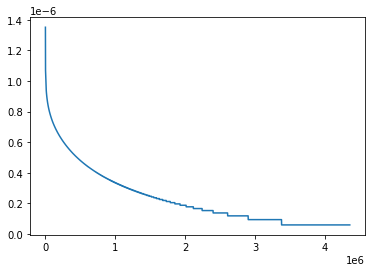

In [399]:
ngrams['freq'].plot()

In [400]:
ngram_dict = dict(ngrams.values)

In [401]:
def get_ngram_probability(ngram):
    return ngram_dict.get(ngram.upper(), 0.)

In [402]:
get_ngram_probability('onthe'), get_ngram_probability('onits'), \
get_ngram_probability('along'), get_ngram_probability('zzewt')

(1.2683566537144875e-06, 9.71814892869308e-07, 1.1183980514470561e-06, 0.0)

In [388]:
%timeit get_ngram_probability('onthe')

168 ns ± 1.4 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


### n-gram score from plaintext

In [403]:
# Hash table-based implementation. 
def plaintext_ngram_score(plaintext, ngram_size):
    score = 0.
    for k in range(len(plaintext) - ngram_size - 1):
        score += get_ngram_probability(plaintext[k:k+ngram_size])
    return 1e6*score

In [404]:
plaintext_ngram_score(singh_codebook_plaintext, ngram_size)

1584.154403603524

In [405]:
worse_test_plaintext = singh_codebook_plaintext.replace('A', 'Z').replace('I','Q')

In [406]:
plaintext_ngram_score(worse_test_plaintext, ngram_size)

701.5274567764485

In [407]:
much_worse_test_plaintext = worse_test_plaintext.replace('E', 'W').replace('O','X').replace('T','P')

In [408]:
plaintext_ngram_score(much_worse_test_plaintext, ngram_size)

45.12948020091018

In [409]:
%timeit plaintext_ngram_score(singh_codebook_plaintext, ngram_size)

610 µs ± 25.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Pertubate key

TODO: This is ugly and probably far from optimal.

In [270]:
def pertubate(cipher_keys):
    
    pertubated_key = copy.deepcopy(cipher_keys)
    
    # Randomly select a plaintext char. 
    plaintext_chars = list(pertubated_key.keys())
    plaintext_weights = [monogram_dict[char] for char in plaintext_chars]
    # plaintext_weights = [1. for char in plaintext_chars]

    while True:
        rand_char = random.choices(plaintext_chars, weights = plaintext_weights)[0]
        if len(pertubated_key[rand_char]) > 0:
            break
    
    # For this key, randomly select a ciphertext symbol. 
    assignments = pertubated_key[rand_char]
    cipher_symbol = random.choice(assignments)
    
    # Remove this symbol from the assignments.
    assignments.remove(cipher_symbol)
    pertubated_key[rand_char] = assignments
    
    # Move the cipher symbol to another plaintext assignment. 
    while True:
        rand_char_2 = random.choices(plaintext_chars, weights = plaintext_weights)[0]
        # Do not undo the pertubation we just made. 
        if rand_char != rand_char_2:
            break
    
    pertubated_key[rand_char_2].append(cipher_symbol)
    
    return pertubated_key

In [271]:
pertubate(cipher_key)

{'U': [59],
 'O': [60, 25, 55],
 'M': [28, 63],
 'E': [10, 14, 40, 45, 30, 58, 0, 27],
 'N': [49, 22, 1, 42],
 'H': [38, 61],
 'D': [34, 26],
 'Y': [19],
 'S': [43, 3, 2, 24],
 'K': [9],
 'L': [11, 37],
 'R': [8, 53, 32, 31],
 'B': [50],
 'V': [29],
 'C': [46, 57, 12],
 'J': [44],
 'A': [17, 16, 36, 33],
 'Q': [4],
 'T': [7, 35, 13, 41, 23, 18],
 'W': [20],
 'F': [39],
 'G': [52],
 'P': [51],
 'I': [62, 54, 5, 48]}

In [32]:
%timeit pertubate(cipher_key)

56.6 µs ± 997 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Swap vowels (UNDER CONSTRUCTION)

In [244]:
from itertools import permutations

In [ ]:
def downhill_vowel_permute(state, score):
    vowel_state = copy.deepcopy(state)
    vowel_score = score
    
    for perm in permutations('AEIOU'):
        
    

### Monogram frequencies

Ref: http://practicalcryptography.com/cryptanalysis/

In [34]:
monograms = pd.read_csv('ngram/english_monograms.txt', sep = ' ', header = None, names = ['ngram', 'freq'])
monograms['freq'] /= monograms['freq'].sum()
monograms = monograms.sort_values(by=['ngram'])

In [35]:
monograms

,ngram,freq
2,A,0.085517
19,B,0.016048
11,C,0.031644
10,D,0.038712
0,E,0.120965
14,F,0.021815
15,G,0.020863
8,H,0.049557
4,I,0.073251
22,J,0.002198


In [36]:
english_unigram_frequencies = list(monograms['freq'].values)

In [37]:
monogram_dict = dict(zip(monograms['ngram'], monograms['freq']))

### Generate initial key

In [38]:
def generate_initial_key(cipher):
    # All unique symbols. 
    ciphertext_symbols = list(dict.fromkeys(cipher))
    # Create empty keys. 
    initial_key = {char : [] for char in alphabet}
    # Randomly assign cipher symbols to alphabet. 
    for symbol in ciphertext_symbols:
        char = random.choices(alphabet, weights = english_unigram_frequencies)[0]
        initial_key[char].append(symbol)
    return initial_key

In [39]:
initial_key_example = generate_initial_key(ciphertext)
initial_key_example

{'A': [39, 18, 23, 16, 1, 7, 9, 53],
 'B': [],
 'C': [43, 45, 13, 30],
 'D': [62, 5],
 'E': [33, 29, 47, 54, 38, 59],
 'F': [],
 'G': [48],
 'H': [44, 56, 22, 26],
 'I': [32, 31, 17, 41],
 'J': [],
 'K': [],
 'L': [14, 20, 37],
 'M': [52, 57],
 'N': [10, 27, 4, 36, 12],
 'O': [63, 50, 3, 55, 28],
 'P': [],
 'Q': [],
 'R': [58, 25],
 'S': [49, 15, 46, 40, 61],
 'T': [8, 2, 21, 34, 24],
 'U': [0],
 'V': [],
 'W': [19],
 'X': [],
 'Y': [60],
 'Z': [6]}

### Given the ciphertext and a decryption key, generate the plaintext

In [446]:
def plaintext_from_key(ciphertext, key):
    # Create inverse key mapping (dict).
    inv_key = dict()
    for k,vs in key.items():
        for v in vs:
            inv_key[v] = k
    # Generate plaintext.
    return [inv_key[c] for c in ciphertext]

In [448]:
%timeit plaintext_example = plaintext_from_key(ciphertext, cipher_key)
plaintext_example = ''.join(plaintext_example)
plaintext_example

66.1 µs ± 1.89 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


'FORCENTURIESKINGSQUEENSANDGENERALSHAVERELIEDONEFFICIENTCOMMUNICATIONINORDERTOGOVERNTHEIRCOUNTRIESANDCOMMANDTHEIRARMIESATTHESAMETIMETHEYHAVEALLBEENAWAREOFTHECONSEQUENCESOFTHEIRMESSAGESFALLINGINTOTHEWRONGHANDSREVEALINGPRECIOUSSECRETSTORIVALNATIONSANDBETRAYINGVITALINFORMATIONTOOPPOSINGFORCESITWASTHETHREATOFENEMYINTERCEPTIONTHATMOTIVATEDTHEDEVELOPMENTOFCODESANDCIPHERSTECHNIQUESFORDISGUISINGAMESSAGESOTHATONLYTHEINTENDEDRECIPIENTCANREADITTHEDESIREFORSECRECYHASMEANTTHATNATIONSHAVEOPERATEDCODEMAKINGDEPARTMENTSWHICHWERERESPONSIBLEFORENSURINGTHESECURITYOFCOMMUNICATIONSBYINVENTINGANDIMPLEMENTINGTHEBESTPOSSIBLECODESATTHESAMETIMEENEMYCODEBREAKERSHAVEATTEMPTEDTOBREAKTHESECODESANDSTEALSECRETSCODEBREAKERSARELINGUISTICALCHEMISTSAMYSTICALTRIBEATTEMPTINGTOCONJURESENSIBLEWORDSOUTOFMEANINGLESSSYMBOLSTHEHISTORYOFCODESANDCIPHERSISTHESTORYOFTHECENTURIESOLDBATTLEBETWEENCODEMAKERSANDCODEBREAKERSANINTELLECTUALARMSRACETHATHASHADADRAMATICIMPACTONTHECOURSEOFHISTORYINWRITINGTHECODEBOOKIHAVEHADTWOMAINOBJECTIVESTHEFI

### Entropy

In [67]:
from scipy.stats import entropy

def plaintext_entropy(plaintext):
    _,counts = np.unique(list(plaintext), return_counts=True)
    return entropy(counts)

In [68]:
plaintext_entropy('ABAABBBAAABBBBAAA')

0.6914160776171183

In [69]:
plaintext_entropy('ONTHEFIRSTDAYOFCHRISTMAS')

2.5568271679009453

In [46]:
plaintext_entropy(z408_plaintext),\
plaintext_entropy(z340_plaintext),\
plaintext_entropy(singh_codebook_plaintext)

(2.8839674453906783, 2.8653004029963824, 2.828053499687207)

### Index of coincidence

In [47]:
def index_of_coincidence(plaintext):
    N = len(plaintext)
    _,counts = np.unique(list(plaintext), return_counts=True)
    ioc = np.sum(counts*(counts-1))
    return float(ioc)/(N*(N-1))

In [48]:
index_of_coincidence(z408_plaintext),\
index_of_coincidence(z340_plaintext),\
index_of_coincidence(singh_codebook_plaintext)

(0.06501421207303561, 0.06510498004511539, 0.0711408411252351)

### Plaintext scoring

The following is _based_ on AZdecrypt's cost function: 

    ent = ngram_score*entropy^solvesub_entweight
    
    solvesub_ngramfactor = (1+((s/l)*solvesub_multiplicityweight))*al*scoretohave/ent

In [439]:
def plaintext_score(plaintext, ngram_size):
    
    # AZdecrypt-based score. 
    score_ngram = plaintext_ngram_score(plaintext, ngram_size)
    score_entropy = plaintext_entropy(plaintext)
    score_multiplicity = multiplicity(plaintext)
    a1 = len(plaintext) - ngram_size + 1
    azd_score = score_ngram*score_entropy/((1. + score_multiplicity)*a1)

    # English plaintext entropy based score. 
    # mean_english_entropy = 2.85
    # entropy_score = math.exp(-(score_entropy - mean_english_entropy)**2)
    
    # Index of coincidence. 
    # mean_english_ioc = 0.067
    # ioc = index_of_coincidence(plaintext)
    # ioc_score = math.exp(-(ioc - mean_english_ioc)**2)
    
    # print(azd_score, entropy_score, ioc_score)
    
    return azd_score # + 0.05*entropy_score + 0.05*ioc_score

In [440]:
plaintext_score(z408_plaintext, ngram_size)

2.338269337952622

In [441]:
plaintext_score(singh_codebook_plaintext, ngram_size)

2.649247308520241

In [442]:
plaintext_score(singh_codebook_plaintext.replace('A','Z').replace('E','W'), ngram_size)

0.8831771480855762

### Score for the candidate key

In [151]:
def state_score(ciphertext, key, ngram_size):
    plaintext = plaintext_from_key(ciphertext, key)
    plaintext = ''.join(plaintext)
    return plaintext_score(plaintext, ngram_size)

In [152]:
state_score(ciphertext, initial_key_example, ngram_size)

0.0019300867454396186

In [147]:
def multiplicity(plaintext):
    return float(len(np.unique(list(plaintext))))/len(plaintext)

### Solve homophonic substitution cipher

In [443]:
def solve_homophonic_substitution_cipher(ciphertext, 
    initial_temperature, 
    cooling_rate,
    n_restarts, 
    n_local, 
    ngram_size = 5,
    initial_key = None,
    downhill = False,
    backtracking = False,
    backtracking_ratio = 0.1, 
    tabu = False,
    tabu_size = 32, 
    permute_vowels = False):
    
    n_explore = 0
    n_downhill = 0
    n_iterations = 0
    n_since_best = 0
    n_backtracks = 0
    best_score = 0
    
    n_tabu = 0
    max_tabu = 8
    tabu_queue = []
    
    vowel_permute_success = False
    
    start = time.time()
    prev = time.time()    
    
    for n_restart in range(n_restarts):

        # Generate initial state (key for the cipher). 
        if initial_key is not None:
            current_state = copy.deepcopy(initial_key)            
        else:
            current_state = generate_initial_key(ciphertext)
        current_score = state_score(ciphertext, current_state, ngram_size)
        
        if n_restart == 0:
            best_state = copy.deepcopy(current_state)
            best_score = current_score
        
        temp = initial_temperature

        while temp > 1:

            # Pertubate current state. 
            neighbour_state = copy.deepcopy(current_state)
            neighbour_score = current_score

            # Permute vowels. (EXPERIMENTAL & UNDER CONSTRUCTION!!)
            if permute_vowels:
                vowel_permute_success, neighbour_state, neighbour_score = \
                    downhill_vowel_permute(neighbour_state, neighbour_score)
            
            # Local (downhill) search.
            local = False
            for _ in range(n_local):
                # Tabu search. 
                i = 0
                while i < max_tabu:
                    i += 1
                    n_iterations += 1
                    n_since_best += 1
                    local_state = pertubate(neighbour_state)
                    local_state_hash = hash(str(list(local_state.values())))
                    if tabu:
                        if local_state_hash not in tabu_queue:
                            tabu_queue.append(local_state_hash)
                            if len(tabu_queue) > tabu_size:
                                tabu_queue.pop(0)
                            break
                        else:
                            n_tabu += 1
                    else:
                        break

                local_score = state_score(ciphertext, local_state, ngram_size)
                if local_score > neighbour_score:
                    local = True
                    neighbour_state = copy.deepcopy(local_state)
                    neighbour_score = local_score

            if not local:
                # neighbour_state = pertubate(current_state)
                # neighbour_score = state_score(ciphertext, neighbour_state, ngram_size)
                neighbour_state = local_state
                neighbour_score = local_score

            # Improved state.  
            if neighbour_score > current_score:
                n_downhill += 1
                current_state = copy.deepcopy(neighbour_state)
                current_score = neighbour_score
                if current_score > best_score:
                    n_since_best = 0
                    best_state = copy.deepcopy(current_state)
                    best_score = current_score
            
            # Downhill or boltzman function.
            if not downhill and math.exp((neighbour_score - current_score)/temp) > random.uniform(0.,1.):
                n_explore += 1
                current_state = copy.deepcopy(neighbour_state)
                current_score = neighbour_score

            # Decrease temperature. 
            temp *= 1.0 - cooling_rate

            # Backtrack to best solution. 
            if backtracking and n_since_best/n_iterations > backtracking_ratio:
                # print('backtracking...')
                n_backtracks += 1
                current_state = copy.deepcopy(best_state)
                current_score = best_score
            
            # debugging. 
            if n_iterations % 10000 == 0:
                iter_per_sec = int(10000/(time.time() - prev))
                prev = time.time()
                
                plaintext = plaintext_from_key(ciphertext, best_state)
                plaintext = ''.join(plaintext)
                ngram_score = plaintext_ngram_score(plaintext, ngram_size)
                ioc = index_of_coincidence(plaintext)
                entropy = plaintext_entropy(plaintext)
                
                print(f'{(time.time() - start)/60.:.2f} mins elapsed')
                print(f'{iter_per_sec} iterations / sec')
                print(f'temperature     = {temp:.2f}')
                print('')
                print(f'best score      = {best_score:.2f}')
                print(f'n-gram          = {ngram_score:.2f}')
                print(f'ioc             = {ioc:.4f}    (english ~0.0686)')
                print(f'entropy         = {entropy:.2f}      (english ~2.85)')
                print('')
                
                plaintext = plaintext_from_key(ciphertext, current_state)
                plaintext = ''.join(plaintext)
                ngram_score = plaintext_ngram_score(plaintext, ngram_size)
                ioc = index_of_coincidence(plaintext)
                entropy = plaintext_entropy(plaintext)

                print(f'current score   = {current_score:.2f}')
                print(f'n-gram          = {ngram_score:.2f}')
                print(f'ioc             = {ioc:.4f}')
                print(f'entropy         = {entropy:.2f}')
                print('')
                
                print(f'n_iterations    = {n_iterations}')
                print(f'n_restart       = {n_restart}')
                print(f'n_backtracks    = {n_backtracks}')
                print(f'n_tabu          = {n_tabu}')
                print(f'n_downhill      = {n_downhill}')
                print(f'n_explore       = {n_explore}')
                print(f'n_since_best    = {n_since_best}')
                print('')
                print(''.join(plaintext_from_key(ciphertext, best_state)))
                print('')
                print(''.join(plaintext_from_key(ciphertext, current_state)))
                print('')
                print(best_state)
                print('')
        # print('restarting...')
    
    return best_score, best_state

In [ ]:
best_score, best_state = solve_homophonic_substitution_cipher(ciphertext, 1e3, 0.001, 10000, 100, 
    tabu = False, backtracking = False)

    2.78 mins elapsed
    567 iterations / sec
    temperature     = 406.39

    best score      = 2.61
    n-gram          = 1563.31
    ioc             = 0.0710    (english ~0.067)
    entropy         = 2.83      (english ~2.85)

    current score   = 2.29
    n-gram          = 1425.29
    ioc             = 0.0789
    entropy         = 2.73

    n_iterations    = 90000
    n_restart       = 0
    n_backtracks    = 0
    n_tabu          = 0
    n_downhill      = 587
    n_explore       = 900
    n_since_best    = 8400

    FORCENTURIESKINGSCUEENSANDGENERALSHAVERELIEMONEFFICIENTCOMMUNICATIONINORDERTOGOVERNTHEIRCOUNTRIESANMCOMMANDTHEIRARMIESATTHESAMETIMETHEYHAVEALLBEENAWAREOFTHECONSECUENCESOFTHEIRMESSAGESFALLINGINTOTHEWRONGHANMSREVEALINGPRECIOUSSECRETSTORIVALNATIONSANDBETRAYINGVITALINFORMATIONTOOPPOSINGFORCESITWASTHETHREATOFENEMYINTERCEPTIONTHATMOTIVATEMTHEDEVELOPMENTOFCOMESANDCIPHERSTECHNICUESFORMISGUISINGAMESSAGESOTHATONLYTHEINTENDEMRECIPIENTCANREADITTHEMESIREFORSECRECYHASMEANTTHATNATIONSHAVEOPERATEDCOMEMAKINGDEPARTMENTSWHICHWERERESPONSIBLEFORENSURINGTHESECURITYOFCOMMUNICATIONSBYINVENTINGANMIMPLEMENTINGTHEBESTPOSSIBLECODESATTHESAMETIMEENEMYCOMEBREAKERSHAVEATTEMPTEDTOBREAKTHESECOMESANDSTEALSECRETSCOMEBREAKERSARELINGUISTICALCHEMISTSAMYSTICALTRIBEATTEMPTINGTOCONJURESENSIBLEWORDSOUTOFMEANINGLESSSYMBOLSTHEHISTORYOFCOMESANDCIPHERSISTHESTORYOFTHECENTURIESOLMBATTLEBETWEENCODEMAKERSANMCODEBREAKERSANINTELLECTUALARMSRACETHATHASHAMADRAMATICIMPACTONTHECOURSEOFHISTORYINWRITINGTHECOMEBOOKIHAVEHADTWOMAINOBJECTIVESTHEFIRSTISTOCHARTTHEEVOLUTIONOFCOMESEVOLUTIONISAWHOLLYAPPROPRIATETERMBECAUSETHEDEVELOPMENTOFCOMESCANBEVIEWEDASANEVOLUTIONARYSTRUGGLEACOMEISCONSTANTLYUNDERATTACKFROMCOMEBREAKERSWHENTHECODEBREAKERSHAVEMEVELOPEDANEWWEAPONTHATREVEALSACOMESWEAKNESSTHENTHECODEISNOLONGERUSEFULITEITHERBECOMESEXTINCTORITEVOLVESINTOANEWSTRONGERCOMEINTURNTHISNEWCODETHRIVESONLYUNTILTHECOMEBREAKERSIDENTIFYITSWEAKNESSANMSOONTHISISSIMILARTOTHESITUATIONFACINGFOREXAMPLEASTRAINOFINFECTIOUSBACTERIATHEBACTERIALIVETHRIVEANDSURVIVEUNTILMOCTORSDISCOVERANANTIBIOTICTHATEXPOSESAWEAKNESSINTHEBACTERIAANMKILLSTHEMTHEBACTERIAAREFORCEDTOEVOLVEANMOUTWITTHEANTIBIOTICANDIFSUCCESSFULTHEYWILLTHRIVEONCEAGAINANMREESTABLISHTHEMSELVES

    {'A': [2, 45, 25, 50, 59], 'B': [41], 'C': [61, 37, 22, 47], 'D': [4], 'E': [33, 7, 0, 10, 40, 53, 20, 54, 42], 'F': [34], 'G': [15], 'H': [46, 51, 30], 'I': [60, 1, 19, 31, 56], 'J': [63], 'K': [8], 'L': [38, 57], 'M': [21, 39], 'N': [3, 27, 48, 23], 'O': [13, 58, 5, 11], 'P': [24], 'Q': [], 'R': [43, 28, 29], 'S': [17, 18, 32, 9], 'T': [44, 16, 55, 36, 49, 12], 'U': [14], 'V': [52], 'W': [35], 'X': [62], 'Y': [26], 'Z': []}

    9.51 mins elapsed
    1776 iterations / sec
    temperature     = 74.55

    best score      = 2.34
    n-gram          = 347.31
    ioc             = 0.0657    (english ~0.067)
    entropy         = 2.87      (english ~2.85)

    current score   = 2.08
    n-gram          = 318.40
    ioc             = 0.0731
    entropy         = 2.76

    n_iterations    = 950000
    n_restart       = 1
    n_backtracks    = 0
    n_tabu          = 0
    n_downhill      = 6896
    n_explore       = 9487
    n_since_best    = 2500

    ILIKEKILLINGPEOPLEBECAUSEITISSOMUCHFUNITIAMOREFUNTHANKILLINGWILDGAMEINTHEFORRESTBECAUSEMANISTHEMOATDANGERTUEANAMALOFALLTOKILLSOMETHINGGIVESMETHEMOATTHRILLINGERPERENCEITISEVENBETTERTHANGETTINGYOURROCKSOFFWITHAGIRLTHEBESTPARTOFITIATHAEWHENIDIEIWILLBEREBORNINPARADICEANDALLTHEIHAVEKILLEDWILLBECOMEMYSLAVESIWILLNOTGIVEYOUMYNAMEBECAUSEYOUWILLTRYTOSLOIDOWNORATOPMYCOLLECTINGOFSLAVESFORMYAFTERLIFEEBEORIETEMETHHPITI

    {'A': ['S', 'G', 'l', '8', '7'], 'B': ['V'], 'C': ['e'], 'D': ['f', 'z'], 'E': ['+', 'N', '6', 'Z', 'E', 'W', 'p'], 'F': ['Q', 'J'], 'G': ['R'], 'H': ['M', ')'], 'I': ['U', 'P', '9', 'k'], 'J': [], 'K': ['/'], 'L': ['%', '#', 'B'], 'M': ['q'], 'N': ['O', '^', '(', 'D'], 'O': ['!', 'X', 'T', 'd'], 'P': ['='], 'Q': [], 'R': ['\\', 't', 'r', 'j'], 'S': ['K', '@', 'F'], 'T': ['H', 'L', 'I', '5'], 'U': ['Y'], 'V': ['c'], 'W': ['A'], 'X': [], 'Y': ['_'], 'Z': []}

In [ ]:
best_score, best_state = solve_homophonic_substitution_cipher(singh_378_55_ciphertext, 1e3, 0.001, 1000, 100,
    tabu = False)

    5.08 mins elapsed
    2178 iterations / sec
    temperature     = 1.66

    best score      = 2.58
    n-gram          = 365.22
    ioc             = 0.0712    (english ~0.067)
    entropy         = 2.80      (english ~2.85)

    n_iterations    = 640000
    n_restart       = 0
    n_backtracks    = 0
    n_tabu          = 0
    n_downhill      = 4470
    n_explore       = 6382
    n_since_best    = 6500

    FORCENTURIESTINGSQUEENSANDGENERALSHAVERELIEDONEFFICIENTCOMMUNICATIONINORDERTOGOVERNTHEIRCOUNTRIESANDCOMMANDTHEIRARMIESATTHESAMETIMETHEYHAVEALLBEENAWAREOFTHECONSEQUENCESOFTHEIRMESSAGESFALLINGINTOTHEWRONGHANDSREVEALINGPRECIOUSSECRETSTORIVALNATIONSANDBETRAYINGVITALINFORMATIONTOOPPOSINGFORCESITWASTHETHREATOFENEMYINTERCEPTIONTHATMOTIVATEDTHEDEVELOPMENTOFCODESANDCIPHERSTECHNIQUESFO

    {'A': [9, 34, 33, 35], 'B': [2], 'C': [20, 52], 'D': [53], 'E': [18, 6, 54, 29, 27, 0, 17], 'F': [10], 'G': [8], 'H': [16, 43], 'I': [22, 28, 49, 30], 'J': [], 'K': [], 'L': [44], 'M': [26, 45], 'N': [3, 48, 23, 39, 38], 'O': [15, 4, 37, 41], 'P': [7], 'Q': [32], 'R': [19, 1, 42], 'S': [40, 46, 11], 'T': [31, 51, 13, 5, 47, 36], 'U': [25], 'V': [24], 'W': [50], 'X': [], 'Y': [21], 'Z': []}

In [ ]:
best_score, best_state = solve_homophonic_substitution_cipher(z340_untransposed, 1e3, 0.001, 1000, 100,
    backtracking = False)

    23.37 mins elapsed
    2215 iterations / sec
    temperature     = 137.93

    best score      = 2.21
    n-gram          = 281.92
    ioc             = 0.0708    (english ~0.067)
    entropy         = 2.79      (english ~2.85)

    current score   = 1.95
    n-gram          = 266.66
    ioc             = 0.0872
    entropy         = 2.59

    n_iterations    = 2960000
    n_restart       = 4
    n_backtracks    = 0
    n_tabu          = 0
    n_downhill      = 22224
    n_explore       = 29566
    n_since_best    = 354300

    IHOPEYOUAREHAVINGLOTSOFFAEINTRYINGTOCATCHMETHATWASSTMESSTHETVSHOWWHICHBRITGOUPAPOINTABOUTMEIAMESTAFRAINOFTHEGASCHAMBERBECAASEITWILLRETIMESSPARALLCEALLTHEROOHERBECAUSEENOWHAVEENOUGHSLAVESTOWORVFORMEWHEREEVERYSSEELREHASTOTHINGWHENTHEYREACHPARALICESOTHEYAREAFRAINOFLEATHIAMESSAFRAINBECAUSEIVESWTHATMYNEWLIFEIRLIFEWILLBEATEARYONEISPARANICEIEATH

    {'A': ['l', 'O', 'K', 'z', '*'], 'B': ['_', 'f'], 'C': ['p'], 'D': [], 'E': ['4', 'N', '|', 'c', '9', 'B', 'b'], 'F': ['F'], 'G': ['L'], 'H': ['+'], 'I': ['k', 'P', '<', 'y', 'H', 'A'], 'J': [], 'K': [], 'L': ['t', 'd', '7', '6'], 'M': ['2'], 'N': ['>', '.', 'S'], 'O': ['V', 'M', 'R'], 'P': ['8', 'j'], 'Q': [], 'R': ['Z', 'T', 'E', 'X', '-', '1'], 'S': ['U', ':', '^', 'J', 'D', '&'], 'T': ['#', '(', 'G', ';', '%', 'Y'], 'U': ['/', '@', 'q'], 'V': ['5'], 'W': ['W', ')'], 'X': [], 'Y': ['3', 'C'], 'Z': []}

Ref: https://github.com/doranchak/azdecrypt/blob/main/AZdecrypt/Ciphers/Substitution/RayN.txt

See also p. 155, The Zodiac Revisited, vol. 2, Michael Cole

In [235]:
ray_nixon_378_ciphertext = \
'R§Ñ∏YWæ∑ΩìZZµj+≥Mô\
B∞VÑTSQA±ö‘—≤•£âXW\
ûJYæä∏ZTæ∑RéA∫§±•Æ\
¥≤ô¬íMπÃ∫√YÀΩ§YZWT\
∏ÑAj∑N¥Bî±íE•≤§SZQ\
≥+µMj¬∏ÀRVÑQJY∑¥éZ\
•+öMVûJTWæº∏£‘√ŒBä\
–Nº∑ôAW∞VÑπ£SE—î±À\
R•XΩô+íµ∏DRÀ+¥VÑÃ≥\
£Àâ¬jûQ≤ôYì∑√¥öVìZ\
•TéA£ôNMæJ±∞VB≤£Æπ\
SWEíäR§À∏YR+PµMZ∑ì\
ΩôDTjA∫—M±≥X≤V¥£Ñû\
îYD¬ÀWöô+ZRÀ+ZV∞£Ñ\
æQTJAΩ•BŒ§SπW≥—±ÃW\
ûä≤WMR∫§DYì√¥ZTW∆æ\
W¥¥£ÀÃA‘âÆP±ìB∏≤§Z\
S∑∞∆PY+NíMπ∫§öôÀ‘E\
ºÃµV∫W—îZR•ûQ¥∏âæj\
¬∑í•TA+√WÑ∞é±ÆBJ≤¥\
äŒ£ÑY∏jN∑éZôÑTRVìA'

In [ ]:
best_score, best_state = solve_homophonic_substitution_cipher(ray_nixon_378_ciphertext, 1e3, 0.001, 1000, 100,
    backtracking = True)

    100.94 mins elapsed
    1974 iterations / sec
    temperature     = 2.18

    best score      = 2.17
    best ioc        = 0.0733    (english ~0.067)
    best entropy    = 2.77      (english ~2.85)

    n_iterations    = 10970000
    n_restart       = 15
    n_backtracks    = 0
    n_tabu          = 0
    n_downhill      = 79856
    n_explore       = 29623
    n_since_best    = 6883400

    ASGREYTRACEEOFDAWNTINGETHEEASTERNSTYTHETHREETRAVELSERSIENOFWILLBEDASEEYERGEFROITHEFORESTEHADOWFORDANGHHERIVERDAWNTHEYTURNSBOTHBOURNEYINGINTOTHEDARTANDFORBADDINGLANDSOFTHENECRBIANCEREVENNOWTHEINTENSITYOFHASDREADPOWERCANBEFELTWEATENINGTHEBODYANDEADDENINGTHEHEARTOSTIYATELYTHEYWALSBECBIEEYPTYIINDLESSSPECTRESETRIPPEDOFWILSANDSOULONLYTHEARTHIRSTFORFREEDBYGIVESTHEIHONGERFORVENGEANCE

    {'A': ['R', 'ö', 'Ω', '≥'], 'B': ['D', '√', '–'], 'C': ['ì'], 'D': ['À', '+'], 'E': ['±', 'Z', 'T', 'A', 'Y', '≤'], 'F': ['j', 'í'], 'G': ['Ñ'], 'H': ['J', 'ä', 'î', 'Q'], 'I': ['π', '¥', '∞'], 'J': [], 'K': [], 'L': ['∫', 'Ã'], 'M': [], 'N': ['ô', 'V', '£'], 'O': ['¬', 'N', 'E', 'µ', 'Œ'], 'P': ['P', '∆'], 'Q': [], 'R': ['∏', '•', '∑'], 'S': ['Æ', '‘', '§', 'â'], 'T': ['—', 'S', 'û', 'æ', 'B', 'X'], 'U': ['º'], 'V': ['é'], 'W': ['M'], 'X': [], 'Y': ['W'], 'Z': []}

In [ ]:
# TODO: add cribs to solve
best_score, best_state = solve_homophonic_substitution_cipher(z340_untransposed[:9*17], 1e3, 0.001, 10000, 10,
    backtracking = False)

Ref: https://github.com/doranchak/azdecrypt/blob/main/AZdecrypt/Ciphers/Substitution/glurk%201.txt

In [453]:
glurk_1 = ">J&9*+%F8$WT13+!#\
4*J{;.RTX*5XC;E1&\
<9=5^<9*;=UC]HM[,\
6[M3=DE}.6K#3]CQD\
L]X-HK-_Q*8B524T-\
Z&<4(7)&MKADKV<K-\
@KMG4@#IW0:N+=L32\
PJ1.Z;@6G#8I;&=5^\
67*-4.;KT$9!ML46C\
;M3V!P+H-Z#7@93SK\
#PBP,W:*Q*1Y,}O%]\
L;,;X:@A#&<GZI6AB\
W4V3OVU17!DZJT7IQ\
KCJH<%$G,P\WVF<{*\
{=8^G#A*=AH{S3|5+\
'%O!MN':OQAV$UECF\
ZOR5FCO(5J8&\"{Q4B\
GSNP_Z_RTW..NVACR\
<@UM{C+M*N4\PMEWZ\
#8_!,<[]4,(WI;XS9"

In [ ]:
best_score, best_state = solve_homophonic_substitution_cipher(glurk_1, 1e3, 0.001, 10000, 100,
    backtracking = False)

Ref: https://github.com/doranchak/azdecrypt/blob/main/AZdecrypt/Ciphers/Substitution/glurk%202.txt

In [455]:
glurk_2 = "j_CN<!J4e7ilK0=B4\
ah0Vl8C7Yk7igO4f:\
D`^=^NeAbKl8F7AlX\
:3d00V_AahZQ2m5dQ\
<mH1JTmml7Wol1ChO\
ehZQD6d@QI3`KF<8Z\
cB76@nWbF!TTZn=P=\
7aebYIgmZJFdYea3Y\
86HRfRDGKMV41VEIF\
2pJfKL6:H`hAiC0O7\
Zo7QAnD65_MQh<QBI\
aRT0FdO^6Na=:HnDf\
>I@k7Mc=4NGlmmW9Y\
HLTiS!J:fFIPED0jf\
KDCIYciKRDfi;o39C\
09<Qd<`N^pZm|hUWK\
Fe4IG@N2B3N2kUNG^\
g3<NMcXDi_L07Zo>h\
EgNWcIEPm^_04n2:f\
|hEE0hWJ|!e4pFdgT"

In [ ]:
best_score, best_state = solve_homophonic_substitution_cipher(glurk_2, 1e3, 0.001, 10000, 100,
    backtracking = False)